In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import re
import numpy as np
import pandas as pd


TEMP_MAP = {"O": 0, "B": 1, "A": 2, "F": 3, "G": 4, "K": 5, "M": 6}
LUM_MAP = {"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}

def parse_sptype(s):
    """
    На вход строка вида 'G5/G6V', 'M1V:', 'F3V', 'G3IV', 'G6III' и т.п.
    Возвращает (temp_code, subclass, lum_code_num)
    """
    if pd.isna(s):
        return np.nan, np.nan, np.nan
    s = str(s).strip().replace(" ", "").replace(":", "")
    temp_char = s[0]
    temp_code = TEMP_MAP.get(temp_char, np.nan)
    nums = re.findall(r"\d+", s)
    if len(nums) == 0:
        subclass = np.nan
    else:
        nums_float = [float(n) for n in nums]
        subclass = float(np.mean(nums_float))
    lum_code_num = np.nan
    for lum_str in ["III", "II", "IV", "V", "I"]:
        if lum_str in s:
            lum_code_num = LUM_MAP[lum_str]
            break

    return temp_code, subclass, lum_code_num

def bv_to_temp(bv):
    if pd.isna(bv):
        return np.nan
    return 4600 * (1/(0.92*bv + 1.7) + 1/(0.92*bv + 0.62))

def plx_to_distance(plx):
    if pd.isna(plx) or plx <= 0:
        return np.nan
    return 1000.0 / plx

def compute_absolute_mag(Vmag, dist_pc):
    if pd.isna(dist_pc) or dist_pc <= 0:
        return np.nan
    return Vmag - 5 * np.log10(dist_pc) + 5




In [35]:
train = pd.read_csv("train_star.csv")
test = pd.read_csv("test_star.csv")
train.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,9.99,7.92,1.61,0.646,G5/G6V,19.483625,Giant
1,10.86,3.26,2.12,1.840,M1V:,18.426088,Giant
2,8.83,7.57,1.05,0.461,F3V,18.225480,Giant
3,7.72,24.80,0.89,0.613,G3IV,19.692257,Giant
4,8.81,3.17,1.03,0.872,G6III,16.315296,Dwarf


In [36]:
train.info

<bound method DataFrame.info of         Vmag    Plx  e_Plx    B-V    SpType       Amag TargetClass
0       9.99   7.92   1.61  0.646    G5/G6V  19.483625       Giant
1      10.86   3.26   2.12  1.840      M1V:  18.426088       Giant
2       8.83   7.57   1.05  0.461       F3V  18.225480       Giant
3       7.72  24.80   0.89  0.613      G3IV  19.692257       Giant
4       8.81   3.17   1.03  0.872     G6III  16.315296       Dwarf
...      ...    ...    ...    ...       ...        ...         ...
20727   7.07  14.88   0.90  0.586       F8V  17.933014       Giant
20728   9.11   4.71   0.87  0.485       F5V  17.475105       Giant
20729   9.69   1.61   1.56  0.384   A2/A3IV  15.724129       Giant
20730   8.06  37.33   0.97  0.758       K1V  20.920290       Giant
20731   9.20   2.22   0.92  1.031  G8III/IV  15.931765       Giant

[20732 rows x 7 columns]>

In [37]:
train.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'TargetClass'], dtype='object')

In [38]:
train["SpType"].nunique()

1681

In [ ]:
train[["Sp_temp", "Sp_subclass", "Sp_lum"]] = \
    train["SpType"].apply(lambda x: pd.Series(parse_sptype(x)))

test[["Sp_temp", "Sp_subclass", "Sp_lum"]] = \
    test["SpType"].apply(lambda x: pd.Series(parse_sptype(x)))

# Температура
train["T_eff"] = train["B-V"].apply(bv_to_temp)
test["T_eff"]  = test["B-V"].apply(bv_to_temp)

# Расстояние
train["Dist_pc"] = train["Plx"].apply(plx_to_distance)
test["Dist_pc"]  = test["Plx"].apply(plx_to_distance)

# Абсолютная величина M_V
train["M_V"] = train.apply(lambda r: compute_absolute_mag(r.Vmag, r.Dist_pc), axis=1)
test["M_V"]  = test.apply(lambda r: compute_absolute_mag(r.Vmag, r.Dist_pc), axis=1)

# Логарифмы
for col in ["T_eff", "Dist_pc"]:
    train[f"log_{col}"] = np.log10(train[col].clip(lower=1e-6))
    test[f"log_{col}"]  = np.log10(test[col].clip(lower=1e-6))


train = train.drop("SpType", axis=1)
test = test.drop("SpType", axis=1)

train.head()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass,Sp_temp,Sp_subclass,Sp_lum,T_eff,Dist_pc,M_V
0,9.99,7.92,1.61,0.646,19.483625,Giant,4.0,5.5,5.0,5793.079693,126.262626,4.483626
1,10.86,3.26,2.12,1.840,18.426088,Giant,6.0,1.0,5.0,3344.743474,306.748466,3.426088
2,8.83,7.57,1.05,0.461,18.225480,Giant,3.0,3.0,5.0,6571.226571,132.100396,3.225479
3,7.72,24.80,0.89,0.613,19.692257,Giant,4.0,3.0,4.0,5917.104412,40.322581,4.692258
4,8.81,3.17,1.03,0.872,16.315296,Dwarf,4.0,6.0,3.0,5072.687407,315.457413,1.315296


In [ ]:

for col in ["Sp_temp", "Sp_subclass", "Sp_lum"]:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)
for col in ["Dist_pc", "M_V", "log_Dist_pc"]:
    median_val = train[col].median()
    train[col] = train[col].fillna(median_val)
    test[col] = test[col].fillna(median_val)

train.isna().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_9836\3343333748.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_9836\3343333748.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Vmag           0
Plx            0
e_Plx          0
B-V            0
Amag           0
TargetClass    0
Sp_temp        0
Sp_subclass    0
Sp_lum         0
T_eff          0
Dist_pc        0
M_V            0
dtype: int64

In [41]:
mapping = {"Dwarf": 0, "Giant": 1}
train["TargetClass"] = train["TargetClass"].map(mapping)

In [42]:
X = train.drop(columns="TargetClass")
y = train["TargetClass"]

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
model = LogisticRegression(max_iter=500, multi_class='multinomial')
model.fit(X_train, y_train)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'multinomial'


In [46]:
y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9676874849288642

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94       988
           1       1.00      0.96      0.98      3159

    accuracy                           0.97      4147
   macro avg       0.94      0.97      0.96      4147
weighted avg       0.97      0.97      0.97      4147



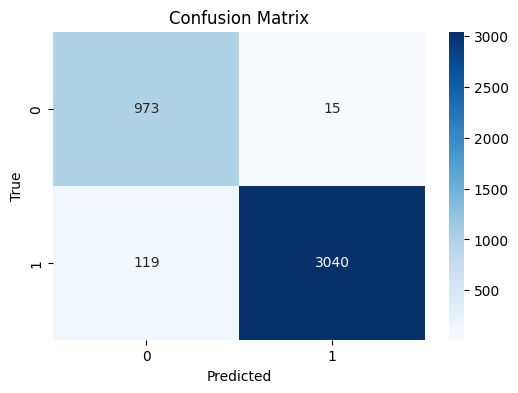

In [47]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [48]:
X_test = test.copy()
X_test_scaled = scaler.transform(X_test)

test_pred = model.predict(X_test_scaled)

submission = pd.DataFrame({
    "index": range(len(test_pred)),
    "TargetClass": test_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()

,index,TargetClass
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
